In [3]:
import os
import torch
from torchvision import transforms
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
timm_kwargs = {
    'model_name': 'vit_giant_patch14_224',
    'img_size': 224, 
    'patch_size': 14, 
    'depth': 24,
    'num_heads': 24,
    'init_values': 1e-5, 
    'embed_dim': 1536,
    'mlp_ratio': 2.66667*2,
    'num_classes': 0, 
    'no_embed_class': True,
    'mlp_layer': timm.layers.SwiGLUPacked, 
    'act_layer': torch.nn.SiLU, 
    'reg_tokens': 8, 
    'dynamic_img_size': True
}
model = timm.create_model(**timm_kwargs)
local_dir = "C:/Users/hua01/Desktop/cwc/SpatialMultimodal/codes/UNI/assets/ckpts/uni2-h/"
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu"), strict=True)
model.eval()
model.to(device)
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

C:\Users\hua01\AppData\Local\Temp\ipykernel_20932\2015156322.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(local_dir, "p

## read sdata and add embedding

In [72]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata
import spatialdata as sd
import spatialdata_plot as sdp  # noqa: F401
import squidpy as sq
# from spatialdata import make_self_contained

from PIL import Image
from tqdm import tqdm
import scanpy as sc

ImportError: cannot import name 'make_self_contained' from 'spatialdata' (C:\Users\hua01\AppData\Local\miniforge3\envs\spd\lib\site-packages\spatialdata\__init__.py)

In [67]:
input_path = 'C:/Users/hua01/Desktop/cwc/SpatialMultimodal/spd_new/'
output_path = 'C:/Users/hua01/Desktop/cwc/SpatialMultimodal/spd_new/UNI'
subfolders = sorted([f.path for f in os.scandir(input_path) if f.is_dir()])
LEAP_folders  = [x for x in subfolders if '.zarr' in x]

In [68]:
len(LEAP_folders)

75

In [83]:
error_msg = []
for folder in LEAP_folders:
    try:
    # if True:
        leap_id = os.path.basename(folder)[:9]
        print(leap_id)
        sdata = sd.read_zarr(folder)
        highest_res_img_key = list(sdata.images["hne"].keys())[0]
        img_da = sdata.images["hne"][highest_res_img_key]["image"]
        img_np = img_da.data.compute().transpose(1, 2, 0)
        hne_pil = Image.fromarray(img_np)
        spots_pixel_gdf = sdata.shapes["spots_tf"]
        radius = spots_pixel_gdf["radius"].iloc[0]
        
        # 遍历每个 spot，截取 patch，提取 embedding
        embeddings = []
        for _, row in tqdm(spots_pixel_gdf.iterrows(), total=len(spots_pixel_gdf)):
            x, y = int(row.geometry.x), int(row.geometry.y)
        
            # 定义 ROI 范围
            left = max(x - radius, 0)
            upper = max(y - radius, 0)
            right = min(x + radius, hne_pil.width)
            lower = min(y + radius, hne_pil.height)
        
            # 截取 ROI，转为 embedding
            patch = hne_pil.crop((left, upper, right, lower))
            patch_tensor = transform(patch).unsqueeze(0).to(device)
        
            with torch.inference_mode():
                emb = model(patch_tensor).cpu().numpy().squeeze()
        
            embeddings.append(emb)
            
        image_emb = np.vstack(embeddings)
        if np.isnan(image_emb).any():
            image_emb = np.nan_to_num(image_emb, nan=0.0)
            
        sdata['adata'].obsm['uni_emb'] = image_emb
        # sdata = make_self_contained(sdata)
        sdata.write(os.path.join(output_path, f"{leap_id}_sdata.zarr"), overwrite=True)
        
        adata = sdata['adata']
        sc.pp.neighbors(adata, use_rep="uni_emb")
        sc.tl.leiden(adata, key_added="leiden_from_UNI")
        
        color_key1 = "leiden_stamp"
        color_key2 = "leiden_from_UNI"
        
        # 2. Create a figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 3. Generate each plot on its specific subplot axis
        
        # Plot 1: Spatial Scatter with 'leiden_stamp' (or fallback)
        sq.pl.spatial_scatter(
            adata,
            color=color_key1,
            ax=axes[0],      # Target the first subplot
            # show=False,    # REMOVE THIS LINE for sq.pl.spatial_scatter
            title=f"Spatial ({color_key1})"
        )
        
        # Plot 2: UMAP
        sc.pl.umap(
            adata,
            color=color_key2,
            ax=axes[1],      # Target the second subplot
            show=False,      # Keep this for sc.pl.umap (it handles it)
            title=f"UMAP ({color_key2})"
        )
        
        # Plot 3: Spatial Scatter with 'leiden'
        sq.pl.spatial_scatter(
            adata,
            color=color_key2,
            ax=axes[2],      # Target the third subplot
            # show=False,    # REMOVE THIS LINE for sq.pl.spatial_scatter
            title=f"Spatial ({color_key2})"
        )
        
        # 4. Adjust layout
        plt.tight_layout()
    
        output_filename = os.path.join(output_path, f"{leap_id}_UNI.jpg")
        # print(f"Saving combined plot to: {output_filename}")
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    
        plt.close(fig)
        
    except Exception as e:
        error_msg.append((leap_id, e))
        print((leap_id, e))
        continue

LEAP-002A


100%|█████████████████████████████████████████████████████████| 1944/1944 [01:29<00:00, 21.73it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-002A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-002A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-002A_sdata.zarr                             
LEAP-002B


100%|███████████████████████████████████████████████████████| 10337/10337 [08:06<00:00, 21.23it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-002B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-002B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-002B_sdata.zarr                             
LEAP-003A


100%|█████████████████████████████████████████████████████████| 3072/3072 [02:30<00:00, 20.47it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-003A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-003A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-003A_sdata.zarr                             
LEAP-003B


100%|█████████████████████████████████████████████████████████| 7882/7882 [06:10<00:00, 21.27it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-003B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-003B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-003B_sdata.zarr                             
LEAP-004A


100%|█████████████████████████████████████████████████████████| 2656/2656 [02:07<00:00, 20.87it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-004A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-004A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-004A_sdata.zarr                             
LEAP-004B


100%|█████████████████████████████████████████████████████████| 6146/6146 [04:54<00:00, 20.86it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-004B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-004B-2_sdata.zarr the new file path:            
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-004B_sdata.zarr                             
LEAP-005B


100%|█████████████████████████████████████████████████████████| 8300/8300 [06:48<00:00, 20.34it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-005B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-005B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-005B_sdata.zarr                             
LEAP-006A


100%|█████████████████████████████████████████████████████████| 2200/2200 [01:45<00:00, 20.89it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-006A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-006A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-006A_sdata.zarr                             
LEAP-006B


100%|█████████████████████████████████████████████████████████| 6586/6586 [05:13<00:00, 21.00it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-006B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-006B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-006B_sdata.zarr                             
LEAP-007A


100%|█████████████████████████████████████████████████████████| 1084/1084 [00:51<00:00, 20.95it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-007A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-007A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-007A_sdata.zarr                             
LEAP-007B


100%|█████████████████████████████████████████████████████████| 7599/7599 [06:03<00:00, 20.93it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-007B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-007B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-007B_sdata.zarr                             
LEAP-008A


100%|█████████████████████████████████████████████████████████| 2118/2118 [01:42<00:00, 20.66it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-008A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-008A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-008A_sdata.zarr                             
LEAP-008B


100%|███████████████████████████████████████████████████████| 10304/10304 [08:08<00:00, 21.07it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-008B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-008B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-008B_sdata.zarr                             
LEAP-010A


100%|█████████████████████████████████████████████████████████| 1755/1755 [01:25<00:00, 20.60it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-010A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-010A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-010A_sdata.zarr                             
LEAP-010B


100%|█████████████████████████████████████████████████████████| 8921/8921 [07:12<00:00, 20.63it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-010B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-010B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-010B_sdata.zarr                             
LEAP-011A


100%|███████████████████████████████████████████████████████████| 735/735 [00:35<00:00, 20.53it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-011A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-011A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-011A_sdata.zarr                             
LEAP-011B


100%|█████████████████████████████████████████████████████████| 7658/7658 [06:09<00:00, 20.73it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-011B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-011B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-011B_sdata.zarr                             
LEAP-012B


100%|█████████████████████████████████████████████████████████| 7458/7458 [06:10<00:00, 20.12it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-012B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-012B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-012B_sdata.zarr                             
LEAP-013A


100%|█████████████████████████████████████████████████████████| 1815/1815 [01:29<00:00, 20.30it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-013A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-013A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-013A_sdata.zarr                             
LEAP-013B


100%|█████████████████████████████████████████████████████████| 8457/8457 [07:02<00:00, 20.02it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-013B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-013B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-013B_sdata.zarr                             
LEAP-014A


 72%|█████████████████████████████████████████▎               | 1511/2087 [01:16<00:29, 19.70it/s]


('LEAP-014A', ValueError("Coordinate 'lower' is less than 'upper'"))
LEAP-014B


100%|█████████████████████████████████████████████████████████| 9738/9738 [07:59<00:00, 20.32it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-014B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-014B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-014B_sdata.zarr                             
LEAP-015A


100%|█████████████████████████████████████████████████████████| 1502/1502 [01:15<00:00, 20.01it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-015A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-015A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-015A_sdata.zarr                             
LEAP-016A


  1%|▌                                                            | 6/668 [00:01<02:56,  3.76it/s]


('LEAP-016A', ValueError("Coordinate 'right' is less than 'left'"))
LEAP-017A


100%|█████████████████████████████████████████████████████████| 2320/2320 [01:56<00:00, 19.92it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-017A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-017A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-017A_sdata.zarr                             
LEAP-017B


100%|█████████████████████████████████████████████████████████| 8967/8967 [07:23<00:00, 20.24it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-017B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-017B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-017B_sdata.zarr                             
LEAP-018A


100%|█████████████████████████████████████████████████████████| 2166/2166 [01:49<00:00, 19.81it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-018A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-018A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-018A_sdata.zarr                             
LEAP-018B


100%|███████████████████████████████████████████████████████| 10724/10724 [08:51<00:00, 20.18it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-018B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-018B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-018B_sdata.zarr                             
LEAP-019A


100%|█████████████████████████████████████████████████████████| 3759/3759 [03:10<00:00, 19.68it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-019A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-019A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-019A_sdata.zarr                             
LEAP-019B


100%|███████████████████████████████████████████████████████| 10946/10946 [08:57<00:00, 20.38it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-019B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-019B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-019B_sdata.zarr                             
LEAP-020A


100%|█████████████████████████████████████████████████████████| 3673/3673 [03:04<00:00, 19.86it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-020A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-020A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-020A_sdata.zarr                             
LEAP-020B


100%|█████████████████████████████████████████████████████████| 6146/6146 [05:06<00:00, 20.06it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-020B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-020B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-020B_sdata.zarr                             
LEAP-021A


100%|█████████████████████████████████████████████████████████| 1285/1285 [01:03<00:00, 20.09it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-021A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-021A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-021A_sdata.zarr                             
LEAP-021B


100%|███████████████████████████████████████████████████████| 11059/11059 [09:07<00:00, 20.18it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-021B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-021B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-021B_sdata.zarr                             
LEAP-022A


  0%|                                                                     | 0/229 [00:00<?, ?it/s]


('LEAP-022A', ValueError("Coordinate 'right' is less than 'left'"))
LEAP-022B


100%|█████████████████████████████████████████████████████████| 7037/7037 [05:51<00:00, 20.02it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-022B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-022B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-022B_sdata.zarr                             
LEAP-023A


100%|█████████████████████████████████████████████████████████| 1045/1045 [00:52<00:00, 20.01it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-023A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-023A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-023A_sdata.zarr                             
LEAP-023B


100%|███████████████████████████████████████████████████████| 10453/10453 [08:36<00:00, 20.23it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-023B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-023B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-023B_sdata.zarr                             
LEAP-024A


100%|███████████████████████████████████████████████████████████| 859/859 [00:43<00:00, 19.65it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-024A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-024A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-024A_sdata.zarr                             
LEAP-024B


100%|███████████████████████████████████████████████████████| 12592/12592 [10:22<00:00, 20.24it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-024B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-024B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-024B_sdata.zarr                             
LEAP-026A


 97%|███████████████████████████████████████████████████████▍ | 1249/1284 [01:03<00:01, 19.64it/s]


('LEAP-026A', ValueError("Coordinate 'lower' is less than 'upper'"))
LEAP-026B


100%|█████████████████████████████████████████████████████████| 8479/8479 [07:01<00:00, 20.14it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-026B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-026B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-026B_sdata.zarr                             
LEAP-027A


100%|█████████████████████████████████████████████████████████| 1257/1257 [01:04<00:00, 19.53it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-027A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-027A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-027A_sdata.zarr                             
LEAP-027B


100%|█████████████████████████████████████████████████████████| 8862/8862 [07:18<00:00, 20.23it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-027B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-027B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-027B_sdata.zarr                             
LEAP-028A


 32%|██████████████████▋                                       | 643/1994 [00:32<01:08, 19.80it/s]


('LEAP-028A', ValueError("Coordinate 'lower' is less than 'upper'"))
LEAP-028B


100%|█████████████████████████████████████████████████████████| 4123/4123 [03:32<00:00, 19.44it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-028B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-028B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-028B_sdata.zarr                             
LEAP-029A


100%|█████████████████████████████████████████████████████████| 2581/2581 [02:09<00:00, 19.95it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-029A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-029A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-029A_sdata.zarr                             
LEAP-029B


100%|███████████████████████████████████████████████████████| 11934/11934 [09:52<00:00, 20.14it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-029B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-029B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-029B_sdata.zarr                             
LEAP-031A


100%|█████████████████████████████████████████████████████████| 2389/2389 [02:00<00:00, 19.75it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-031A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-031A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-031A_sdata.zarr                             
LEAP-031B


100%|█████████████████████████████████████████████████████████| 9453/9453 [07:56<00:00, 19.85it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-031B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-031B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-031B_sdata.zarr                             
LEAP-032A


 30%|█████████████████▋                                        | 619/2032 [00:32<01:13, 19.28it/s]


('LEAP-032A', ValueError("Coordinate 'lower' is less than 'upper'"))
LEAP-032B


100%|█████████████████████████████████████████████████████████| 9679/9679 [08:01<00:00, 20.08it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-032B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-032B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-032B_sdata.zarr                             
LEAP-033A


100%|█████████████████████████████████████████████████████████| 2825/2825 [02:20<00:00, 20.05it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-033A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-033A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-033A_sdata.zarr                             
LEAP-033B


100%|███████████████████████████████████████████████████████| 12717/12717 [10:40<00:00, 19.86it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-033B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-033B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-033B_sdata.zarr                             
LEAP-034A


100%|█████████████████████████████████████████████████████████| 2309/2309 [01:56<00:00, 19.78it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-034A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-034A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-034A_sdata.zarr                             
LEAP-034B


100%|█████████████████████████████████████████████████████████| 8619/8619 [07:12<00:00, 19.93it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-034B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-034B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-034B_sdata.zarr                             
LEAP-035A


100%|█████████████████████████████████████████████████████████| 1876/1876 [01:35<00:00, 19.73it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-035A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-035A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-035A_sdata.zarr                             
LEAP-035B


100%|█████████████████████████████████████████████████████████| 2865/2865 [02:25<00:00, 19.72it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-035B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-035B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-035B_sdata.zarr                             
LEAP-036A


100%|███████████████████████████████████████████████████████████| 446/446 [00:22<00:00, 19.61it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-036A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-036A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-036A_sdata.zarr                             
LEAP-036B


100%|█████████████████████████████████████████████████████████| 8381/8381 [06:56<00:00, 20.11it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-036B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-036B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-036B_sdata.zarr                             
LEAP-037A


 11%|██████▏                                                   | 254/2371 [00:12<01:45, 20.03it/s]


('LEAP-037A', AssertionError('Input width (1728) should be divisible by patch size (14).'))
LEAP-037B


100%|█████████████████████████████████████████████████████████| 9266/9266 [07:42<00:00, 20.02it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-037B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-037B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-037B_sdata.zarr                             
LEAP-038A


100%|█████████████████████████████████████████████████████████| 3820/3820 [03:09<00:00, 20.15it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-038A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-038A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-038A_sdata.zarr                             
LEAP-038B


100%|███████████████████████████████████████████████████████| 10401/10401 [08:41<00:00, 19.95it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-038B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-038B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-038B_sdata.zarr                             
LEAP-039A


100%|█████████████████████████████████████████████████████████| 2312/2312 [01:56<00:00, 19.78it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-039A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-039A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-039A_sdata.zarr                             
LEAP-039B


100%|█████████████████████████████████████████████████████████| 8991/8991 [07:31<00:00, 19.93it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-039B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-039B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-039B_sdata.zarr                             
LEAP-041A


100%|█████████████████████████████████████████████████████████| 1033/1033 [00:52<00:00, 19.73it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-041A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-041A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-041A_sdata.zarr                             
LEAP-041B


100%|█████████████████████████████████████████████████████████| 6027/6027 [05:03<00:00, 19.87it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-041B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-041B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-041B_sdata.zarr                             
LEAP-042A


100%|█████████████████████████████████████████████████████████| 4323/4323 [03:35<00:00, 20.08it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-042A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-042A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-042A_sdata.zarr                             
LEAP-042B


100%|█████████████████████████████████████████████████████████| 9741/9741 [08:12<00:00, 19.76it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-042B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-042B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-042B_sdata.zarr                             
LEAP-044A


100%|█████████████████████████████████████████████████████████| 2248/2248 [01:54<00:00, 19.70it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-044A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-044A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-044A_sdata.zarr                             
LEAP-044B


100%|█████████████████████████████████████████████████████████| 7792/7792 [06:27<00:00, 20.13it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-044B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-044B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-044B_sdata.zarr                             
LEAP-046A


100%|█████████████████████████████████████████████████████████| 3294/3294 [02:47<00:00, 19.71it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-046A_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-046A_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-046A_sdata.zarr                             
LEAP-046B


100%|█████████████████████████████████████████████████████████| 5710/5710 [04:42<00:00, 20.19it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-046B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-046B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-046B_sdata.zarr                             
LEAP-047B


100%|█████████████████████████████████████████████████████████| 6377/6377 [05:17<00:00, 20.09it/s]


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-047B_sdata.zarr). Please  
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\LEAP-047B_sdata.zarr the new file path:              
         C:\Users\hua01\Desktop\cwc\SpatialMultimodal\spd_new\UNI\LEAP-047B_sdata.zarr                             


In [76]:
sdata = sd.read_zarr('C:/Users/hua01/Desktop/cwc/SpatialMultimodal/spd_new/LEAP-002A_sdata.zarr')

In [92]:
adata.obsp

AttributeError: 'PairwiseArrays' object has no attribute 'uns'

In [86]:
adata.obsp['distances']

<6377x6377 sparse matrix of type '<class 'numpy.float64'>'
	with 89278 stored elements in Compressed Sparse Row format>

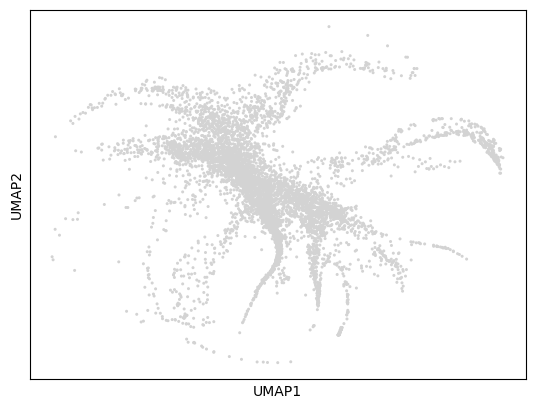

In [91]:
sc.pl.umap(adata, neighbors_key='connectivities')

In [78]:
uni_emb = adata.obsm['uni_emb']

In [79]:
uni_emb.shape

(1944, 1536)

In [80]:
sdata['adata'].obsm['uni_emb'] = uni_emb

In [81]:
sdata['adata'].obsm

AxisArrays with keys: X_pca, X_scVI, X_stamp, X_umap, X_umap_c2l_Midlevel, X_umap_pca, X_umap_scvi, _scvi_extra_categorical_covs, _scvi_extra_continuous_covs, hne_emb, means_cell_abundance_w_sf, q05_cell_abundance_w_sf, q05_cell_abundance_w_sf_c2l_Midlevel, q95_cell_abundance_w_sf, spatial, stds_cell_abundance_w_sf, uni_emb

In [82]:
sdata.write_element("adata", overwrite=True)

ValueError: Cannot overwrite. The target path of the write operation is in use. Please save the data to a different location. 
Details: the target path in which to save an element is a subfolder of the current Zarr store.
Workaround: please see discussion here https://github.com/scverse/spatialdata/discussions/520 .

In [71]:
error_msg

[('LEAP-002A', NameError("name 'make_self_contained' is not defined"))]

In [61]:
adata = sdata['adata']
sc.pp.neighbors(adata, use_rep="uni_emb")
sc.tl.leiden(adata, key_added="leiden_from_UNI")

color_key1 = "leiden_stamp"
color_key2 = "leiden_from_embedding"

# 2. Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 3. Generate each plot on its specific subplot axis

# Plot 1: Spatial Scatter with 'leiden_stamp' (or fallback)
sq.pl.spatial_scatter(
    adata,
    color=color_key1,
    ax=axes[0],      # Target the first subplot
    # show=False,    # REMOVE THIS LINE for sq.pl.spatial_scatter
    title=f"Spatial ({color_key1})"
)

# Plot 2: UMAP
sc.pl.umap(
    adata,
    color=color_key2,
    ax=axes[1],      # Target the second subplot
    showoutput_path=False,      # Keep this for sc.pl.umap (it handles it)
    title=f"UMAP ({color_key2})"
)

# Plot 3: Spatial Scatter with 'leiden'
sq.pl.spatial_scatter(
    adata,
    color=color_key2,
    ax=axes[2],      # Target the third subplot
    # show=False,    # REMOVE THIS LINE for sq.pl.spatial_scatter
    title=f"Spatial ({color_key2})"
)

# 4. Adjust layout
plt.tight_layout()
output_filename = os.path.join(output_path, 'UNI', f"{leap_id}_UNI.jpg")
# print(f"Saving combined plot to: {output_filename}")
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

plt.close(fig)